# POS Tagging Using PhoBERT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Projects/POS Tagging/BERT

/content/drive/MyDrive/Projects/POS Tagging/BERT


## Import libraries

In [ ]:
!pip install transformers
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
from gensim.models import KeyedVectors
from gensim.models.wrappers import FastText
## for deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
# for bert
from transformers import AutoModel, AutoTokenizer

In [ ]:
phobert = AutoModel.from_pretrained("vinai/phobert-base")

# For transformers v4.x+: 
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [ ]:
# Read txt
def read_txt(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return lines
  

def format_data(text_l):
    sent_l = []
    for sent in text_l:
        tuple_l = []
        tuple_words = sent.strip('\n').split()
        for tup in tuple_words:
            split = tup.split('/')
            if len(split) < 2:
                continue
            split_word = '/'.join(split[:-1])
            split_tag = split[-1]
            
            tuple_l.append((split_word, split_tag))
        sent_l.append(tuple_l)
    return sent_l

In [ ]:
train_text_l = read_txt('../data/train.txt')
val_text_l = read_txt('../data/val.txt')
test_text_l = read_txt('../data/test.txt')

train_sent_l = format_data(train_text_l)
val_sent_l = format_data(val_text_l)
test_sent_l = format_data(test_text_l)

In [ ]:
labels_s = set()
idx = 1
for sent in train_sent_l:
    for tup in sent:
        labels_s.add(tup[1])
labels_l = list(labels_s)
label2idx, idx2label = {}, {}
for i, label in enumerate(labels_l):
    label2idx[label] = i + 1
    idx2label[i] = label

In [ ]:
label2idx

In [ ]:
train_sent_l = [[tup for tup in sent if tup[1] in label2idx] for sent in train_sent_l]
val_sent_l = [[tup for tup in sent if tup[1] in label2idx] for sent in val_sent_l]
test_sent_l = [[tup for tup in sent if tup[1] in label2idx] for sent in test_sent_l]

In [ ]:
train_text_l = [[tup[0] for tup in sent] for sent in train_sent_l]
val_text_l = [[tup[0] for tup in sent] for sent in val_sent_l]
test_text_l = [[tup[0] for tup in sent] for sent in test_sent_l]

In [ ]:
train_label_l = [[label2idx[tup[1]] for tup in sent] for sent in train_sent_l]
val_label_l = [[label2idx[tup[1]] for tup in sent] for sent in val_sent_l]
test_label_l = [[label2idx[tup[1]] for tup in sent] for sent in test_sent_l]

In [ ]:
print(train_sent_l[0], val_sent_l[0], test_sent_l[0])
print(train_text_l[0], val_text_l[0], test_text_l[0])
print(train_label_l[0], val_label_l[0], test_label_l[0])

## EDA

In [ ]:
train_number_words = [len(sent) for sent in train_text_l]
val_number_words = [len(sent) for sent in val_text_l]
test_number_words = [len(sent) for sent in test_text_l]

In [ ]:
max(train_number_words), max(val_number_words), max(test_number_words)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

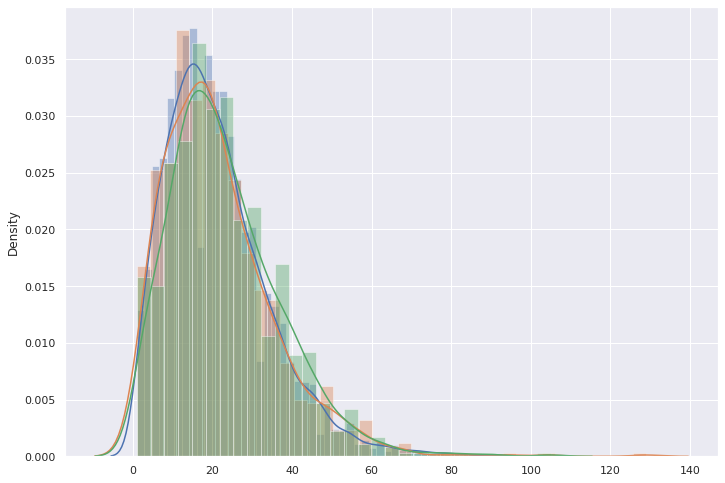

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(train_number_words, hist=True, label='train')
sns.distplot(val_number_words, hist=True, label='test')
sns.distplot(test_number_words, hist=True, label='test')

## Encode text

In [ ]:
def encode_sentence(text, maxlen):
    l = len(text)
    text.insert(0, '<s>')
    text.append('</s>')
    encoded = np.zeros((maxlen, 768))
    
    input_ids = tokenizer.convert_tokens_to_ids(text)
    input_ids = torch.tensor([input_ids])
    with torch.no_grad():
        features = phobert(input_ids)[0].reshape(l + 2, 768)
    
    for i in range(l):
        encoded[i] = features[i + 1]

    return encoded


def encode_label(label, maxlen):
    encoded = np.zeros(maxlen, dtype=int)
    length = len(label)
    encoded[:length] = label
    return encoded

In [ ]:
X_train_lengths = [len(text) for text in train_text_l]
X_val_lengths = [len(text) for text in val_text_l]
X_test_lengths = [len(text) for text in test_text_l]

y_train_lengths = [len(label) for label in train_label_l]
y_val_lengths = [len(label) for label in val_label_l]
y_test_lengths = [len(label) for label in test_label_l]

In [ ]:
X_train = [encode_sentence(text, 130) for text in train_text_l]
X_val = [encode_sentence(text, 130) for text in val_text_l]
X_test = [encode_sentence(text, 130) for text in test_text_l]

y_train = [encode_label(label, 130) for label in train_label_l]
y_val = [encode_label(label, 130) for label in val_label_l]
y_test = [encode_label(label, 130) for label in test_label_l]

## Dataset and Dataloader

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx].astype(np.float64)), torch.from_numpy(self.y[idx].astype(np.long))

In [ ]:
train_ds = TextDataset(X_train, y_train)
dev_ds = TextDataset(X_val, y_val)
test_ds = TextDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
dev_loader = DataLoader(dev_ds, batch_size=1, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

## Model

In [ ]:
class LinearClassifier(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
      
    def forward(self, x):
        linear = self.fc(x).permute(0, 2, 1)
        output = self.softmax(linear)
        return output

## Checkpoint

In [ ]:
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

## Train model

In [ ]:
# Training Function
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device {device}')
writer = SummaryWriter('logs')

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(ignore_index=0),
          train_loader = train_loader,
          dev_loader = dev_loader,
          num_epochs = 1000,
          file_path = 'pretrained_model/model_lstm_word2vec.pt'
          ):
    
    # initialize running values
    best_dev_loss = float("Inf")
    train_running_loss = 0.0
    dev_running_loss = 0.0
    train_loss_list = []
    dev_loss_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        print(f'Training epochs {epoch + 1}/{num_epochs}')
        for i, (features, labels) in enumerate(train_loader):
            features = features.to(device)          
            labels = labels.to(device)
            output = model(features)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            # running_loss += loss.item()

        # evaluation step

        model.eval()
        train_correct, train_total, dev_correct, dev_total = 0, 0, 0, 0
        with torch.no_grad():                    
        # devation loop
          
          for features, labels in train_loader:
              features = features.to(device)
              labels = labels.to(device)
              output = model(features)
              loss = criterion(output, labels)
              train_running_loss += loss.item()

              _, predicted = torch.max(output.data, 1)
              train_total += labels.size(0) * labels.size(1)
              train_correct += (predicted == labels).sum().item()
          
          for features, labels in dev_loader:
              features = features.to(device) 
              labels = labels.to(device)
              output = model(features)

              loss = criterion(output, labels)
              dev_running_loss += loss.item()

              _, predicted = torch.max(output.data, 1)
              dev_total += labels.size(0) * labels.size(1)
              print(labels)
              dev_correct += (predicted == labels).sum().item()

        print(f'Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_running_loss} Dev Loss: {dev_running_loss} Train acc: {round(train_correct / train_total, 2)} Dev acc: {round(dev_correct/dev_total, 2)}')
        print(f'Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_running_loss} Dev Loss: {dev_running_loss} Train acc: {round(train_correct / train_total, 2)} Dev acc: {round(dev_correct/dev_total, 2)}')
        writer.add_scalar('Loss/train', train_running_loss, epoch)
        writer.add_scalar('Loss/dev', dev_running_loss, epoch)
        writer.add_scalar('Accuracy/train', round(train_correct / train_total, 2), epoch)
        writer.add_scalar('Accuracy/test', round(dev_correct/dev_total, 2), epoch)

        # evaluation
        train_loss_list.append(train_running_loss)
        dev_loss_list.append(dev_running_loss)

        # resetting running values
        
                  
        # checkpoint
        if best_dev_loss > dev_running_loss:
            best_dev_loss = dev_running_loss
            save_checkpoint(file_path, model, optimizer, best_dev_loss)
    
        train_running_loss = 0.0                
        dev_running_loss = 0.0
        model.train()
    writer.close()
    print('Finished Training!')

Device cpu


In [ ]:
model = LinearClassifier(768, len(label2idx) + 1).double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=500, file_path = 'pretrained_model/bert.pt')